In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

Using TensorFlow backend.


In [ ]:
# For progress visualization when training the model
#pip install keras_tqdm
#pip install ipywidgets
#jupyter nbextension enable --py widgetsnbextension

In [23]:
# preproccess the image to array
def load_image(img_file, target_size=(224,224)):
    '''
    img_file: path of the image file
    '''
    
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

# check if the folder exists
import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
# default mobilenet model summary
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

W1114 01:17:30.084007 140694310307520 deprecation.py:506] From /home/anku5h/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [13]:
# get image by name
dog_image_id = os.listdir('./datasets/my_model/val_images/dog_val')[0] # 0 is index to select first image from folder
dog_image = load_image(os.path.join('./datasets/my_model/val_images/dog_val', dog_image_id))

In [6]:
dog_image.min()

-1.0

In [26]:
cat_image_id = os.listdir('./datasets/my_model/val_images/cat_val')[0]
cat_image = load_image(os.path.join('./datasets/my_model/val_images/cat_val', cat_image_id))

In [25]:
print(f'shape: {dog_image.shape}')

shape: (1, 224, 224, 3)


In [29]:
np.argmax(model.predict(cat_image)) # cat id in imagenet

285

In [17]:
np.argmax(model.predict(dog_image)) # dog id in imagenet

255

Creating a new mobilnet model to use it for transfer learning

In [18]:
model = tf.keras.applications.mobilenet.MobileNet(
  input_shape=(224, 224, 3), # our input image dimension
  include_top=False, # to not include the fully-connected layer at the top of the network.
  pooling='avg'
)

In [31]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)

# Dropout layer randomly sets input units to fraction rate(0 to 1) to 0 at each update, which helps prevent overfitting.
x = Dropout(rate = 0.4)(model.output)
x = Dense(2)(x)
x = Softmax()(x)
model = Model(model.inputs, x)

In [20]:
# making the top layers non-trainable, as top layers are already trained to recognize objects so no need to change their parameters
for layer in model.layers[:-3]:
    layer.trainable = False

In [53]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [21]:
# compiling model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr=0.01),
             loss = 'categorical_crossentropy'
             )

In [15]:
from tensorflow.keras.applications import mobilenet as _mobilenet

# creating training and validation set
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('./datasets/my_model/training_dogs')
training = datagen.flow_from_directory( 
    './datasets/my_model/train_images', 
    target_size=(224, 224),
    subset='training'
) 

ensure_folder_exists('./datasets/my_model/validations_dogs')
validation = datagen.flow_from_directory( 
    './datasets/my_model/val_images',
    target_size=(224, 224),
    subset='validation'
)

Found 900 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [23]:
# training the lower layers
batch_size = 32 # samples per epoch, batch training.
history = model.fit_generator(
    generator=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
28/28 [==============================] - 74s 3s/step - loss: 0.7984 - val_loss: 0.4564
Epoch 2/10
28/28 [==============================] - 68s 2s/step - loss: 0.1534 - val_loss: 0.2115
Epoch 3/10
28/28 [==============================] - 69s 2s/step - loss: 0.1440 - val_loss: 0.0955
Epoch 4/10
28/28 [==============================] - 67s 2s/step - loss: 0.1018 - val_loss: 0.2674
Epoch 5/10
28/28 [==============================] - 67s 2s/step - loss: 0.1737 - val_loss: 0.3786
Epoch 6/10
28/28 [==============================] - 67s 2s/step - loss: 0.1783 - val_loss: 0.1695
Epoch 7/10
28/28 [==============================] - 69s 2s/step - loss: 0.0933 - val_loss: 0.2490
Epoch 8/10
28/28 [==============================] - 67s 2s/step - loss: 0.0649 - val_loss: 0.2900
Epoch 9/10
28/28 [==============================] - 69s 2s/step - loss: 0.0738 - val_loss: 0.1474
Epoch 10/10
28/28 [==============================] - 65s 2s/step - loss: 0.1693 - val_loss: 0.3971


So almost with 280 images or classifier is trained to a adequate train loss and val loss

In [33]:
np.argmax(model.predict(dog_image)) # dog is 1

1

In [31]:
np.argmax(model.predict(cat_image)) # cat is 0

0

In [42]:
# testing with new image for convinience
dog_image_id = os.listdir('./datasets/my_model/val_images/dog_val')[76]
dog_image_2 = load_image(os.path.join('./datasets/my_model/val_images/dog_val', dog_image_id))

In [43]:
np.argmax(model.predict(dog_image_2))

1

In [83]:
np.round(model.predict(dog_image_2), 2)

array([[0., 1.]], dtype=float32)

In [67]:
cat_image_id = os.listdir('./datasets/my_model/val_images/cat_val')[9]
cat_image_2 = load_image(os.path.join('./datasets/my_model/val_images/cat_val', cat_image_id))

In [82]:
arr = model.predict(cat_image_2)

array([[1.000000e+00, 2.242042e-10]], dtype=float32)

In [50]:
# perfect

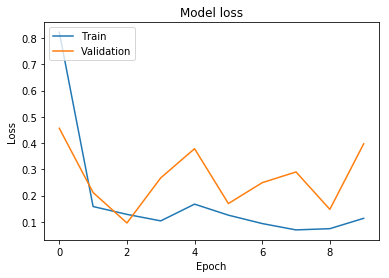

In [56]:
# drawing a learning curve
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()